# Focus on Cycling cells

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import doubletdetection
import warnings
warnings.filterwarnings('ignore')

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

/home/lebrigand/.conda/envs/jupyter/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.3 scipy==1.3.3 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.2 python-igraph==0.7.1 louvain==0.6.1


In [2]:
sc.settings.set_figure_params(dpi=130)

In [3]:
adata_ann = sc.read_h5ad('./output/wt.ann.h5ad')
adata_raw = sc.read_h5ad('./output/wt.preprocessing.h5ad')
adata_raw.shape

(3290, 12958)

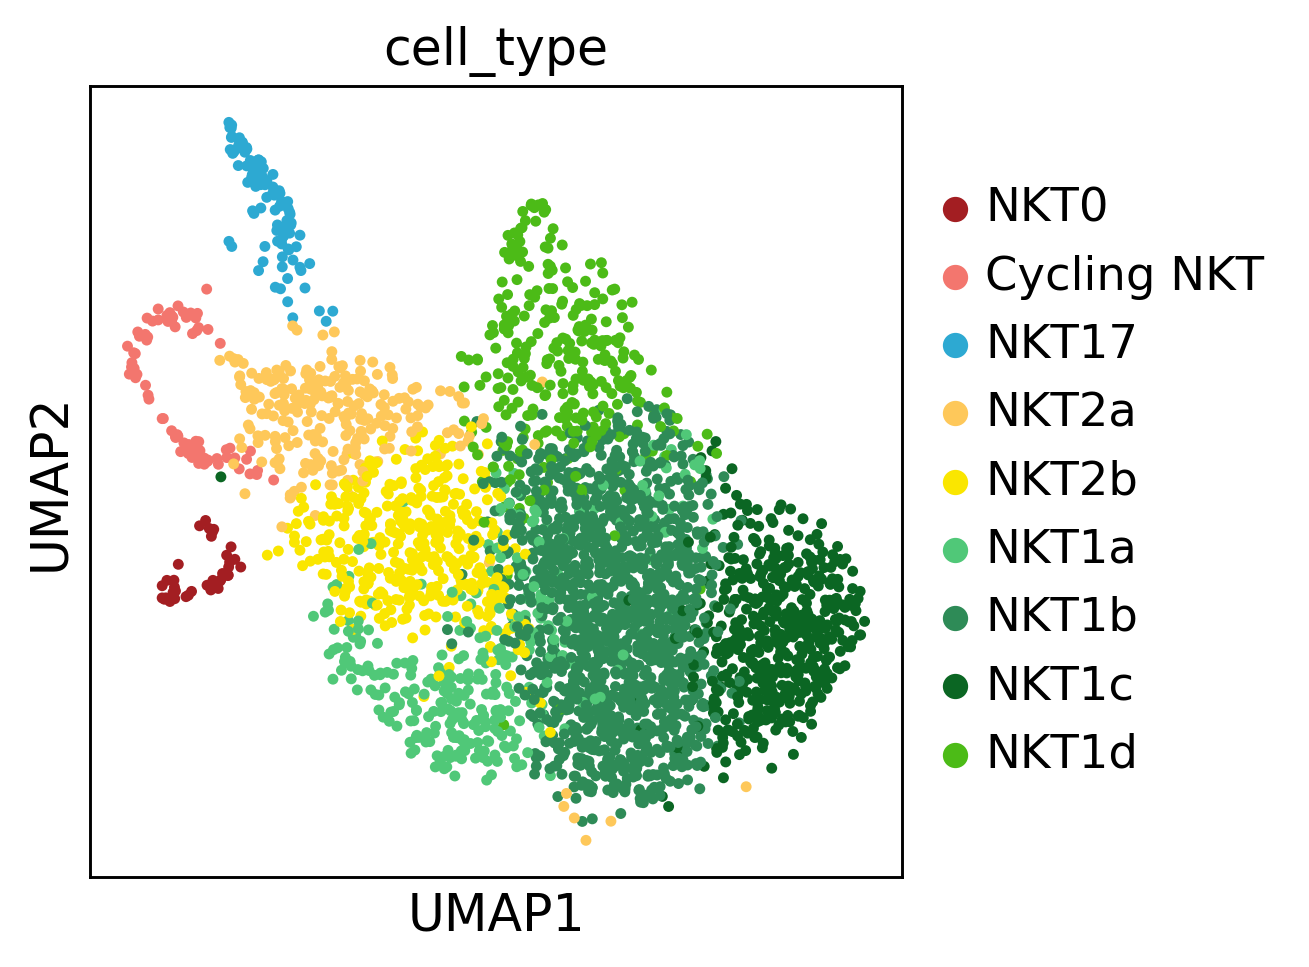

In [4]:
sc.pl.umap(adata_ann, color=['cell_type'])

In [5]:
# cell cycle scoring
cell_cycle_genes = [x.strip() for x in open('/data/10x_data/cell_cycle_vignette_files/regev_lab_cell_cycle_genes_mouse.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata_raw.var_names]
sc.tl.score_genes_cell_cycle(adata_ann, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs) (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs) (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [6]:
# le top50 des markers de tous les clusters sauf le cycling NKT
top50 = [x.strip() for x in open('/data/10x_data/000-notebooks/10x_paget/top50_273.txt')]
len(top50)

273

In [7]:
#tokeep = []
#for x in adata_ann.obs['cell_type']:
#    tokeep = tokeep + [x in ['Cycling NKT']]

tokeep = adata_ann.obs['cell_type'] == ['Cycling NKT']
list_of_cell_names = adata_ann.obs_names[tokeep]
adata_cc = adata_raw[list_of_cell_names, ]
adata_cc.obs['cell_type'] = adata_ann.obs['cell_type']
adata_cc.obs['phase'] = adata_ann.obs['phase'] 
adata_cc.obs['G2M_score'] = adata_ann.obs['G2M_score'] 
adata_cc.obs['S_score'] = adata_ann.obs['S_score'] 
adata_cc.shape

Trying to set attribute `.obs` of view, making a copy.


(81, 12958)

In [8]:
sc.pp.filter_genes(adata_cc, min_cells=3)

filtered out 3543 genes that are detectedin less than 3 cells


In [9]:
top50 = [x for x in top50 if x in adata_cc.var_names]
top50 = [x for x in top50 if not x in cell_cycle_genes]
len(top50)

270

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
    finished (0:00:00)


... storing 'phase' as categorical


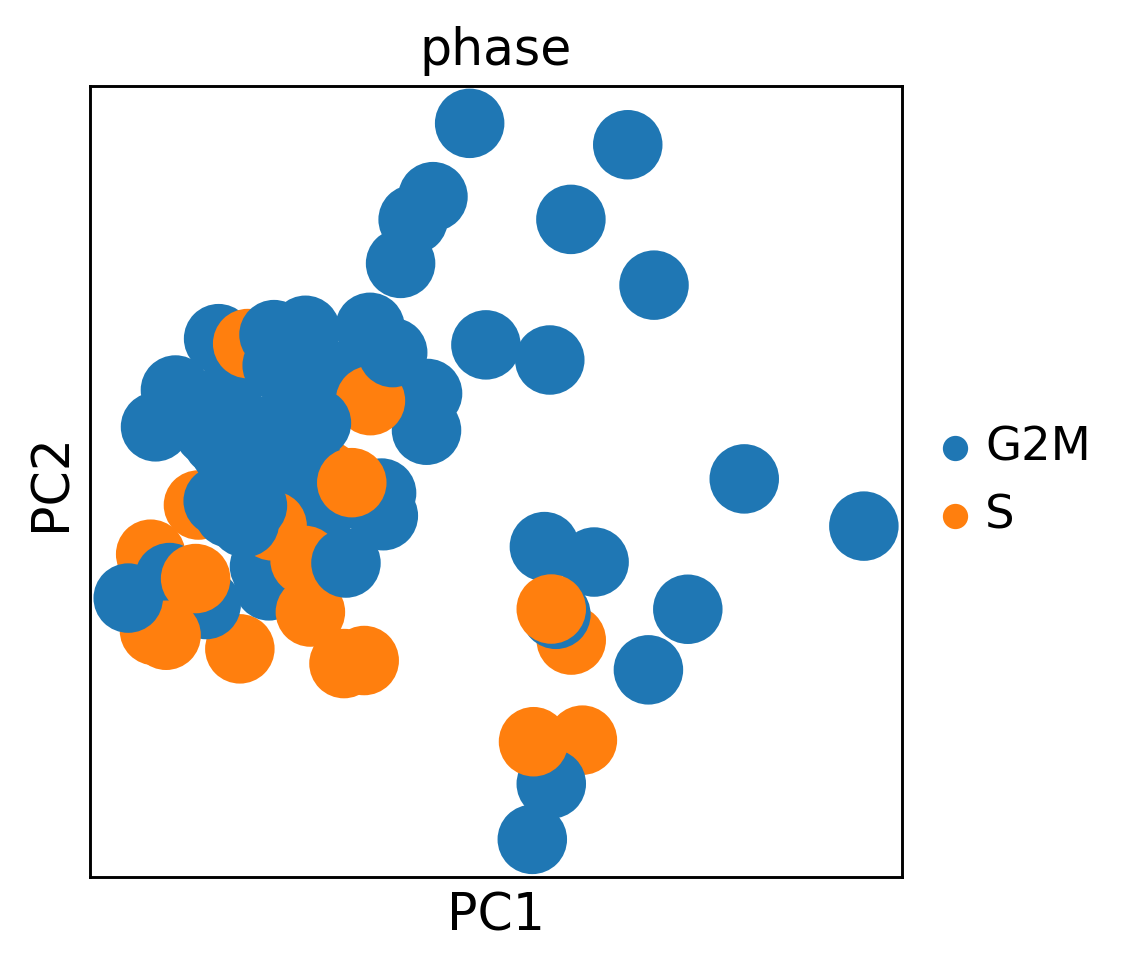

In [10]:
adata_cc_genes = adata_cc[:, top50]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


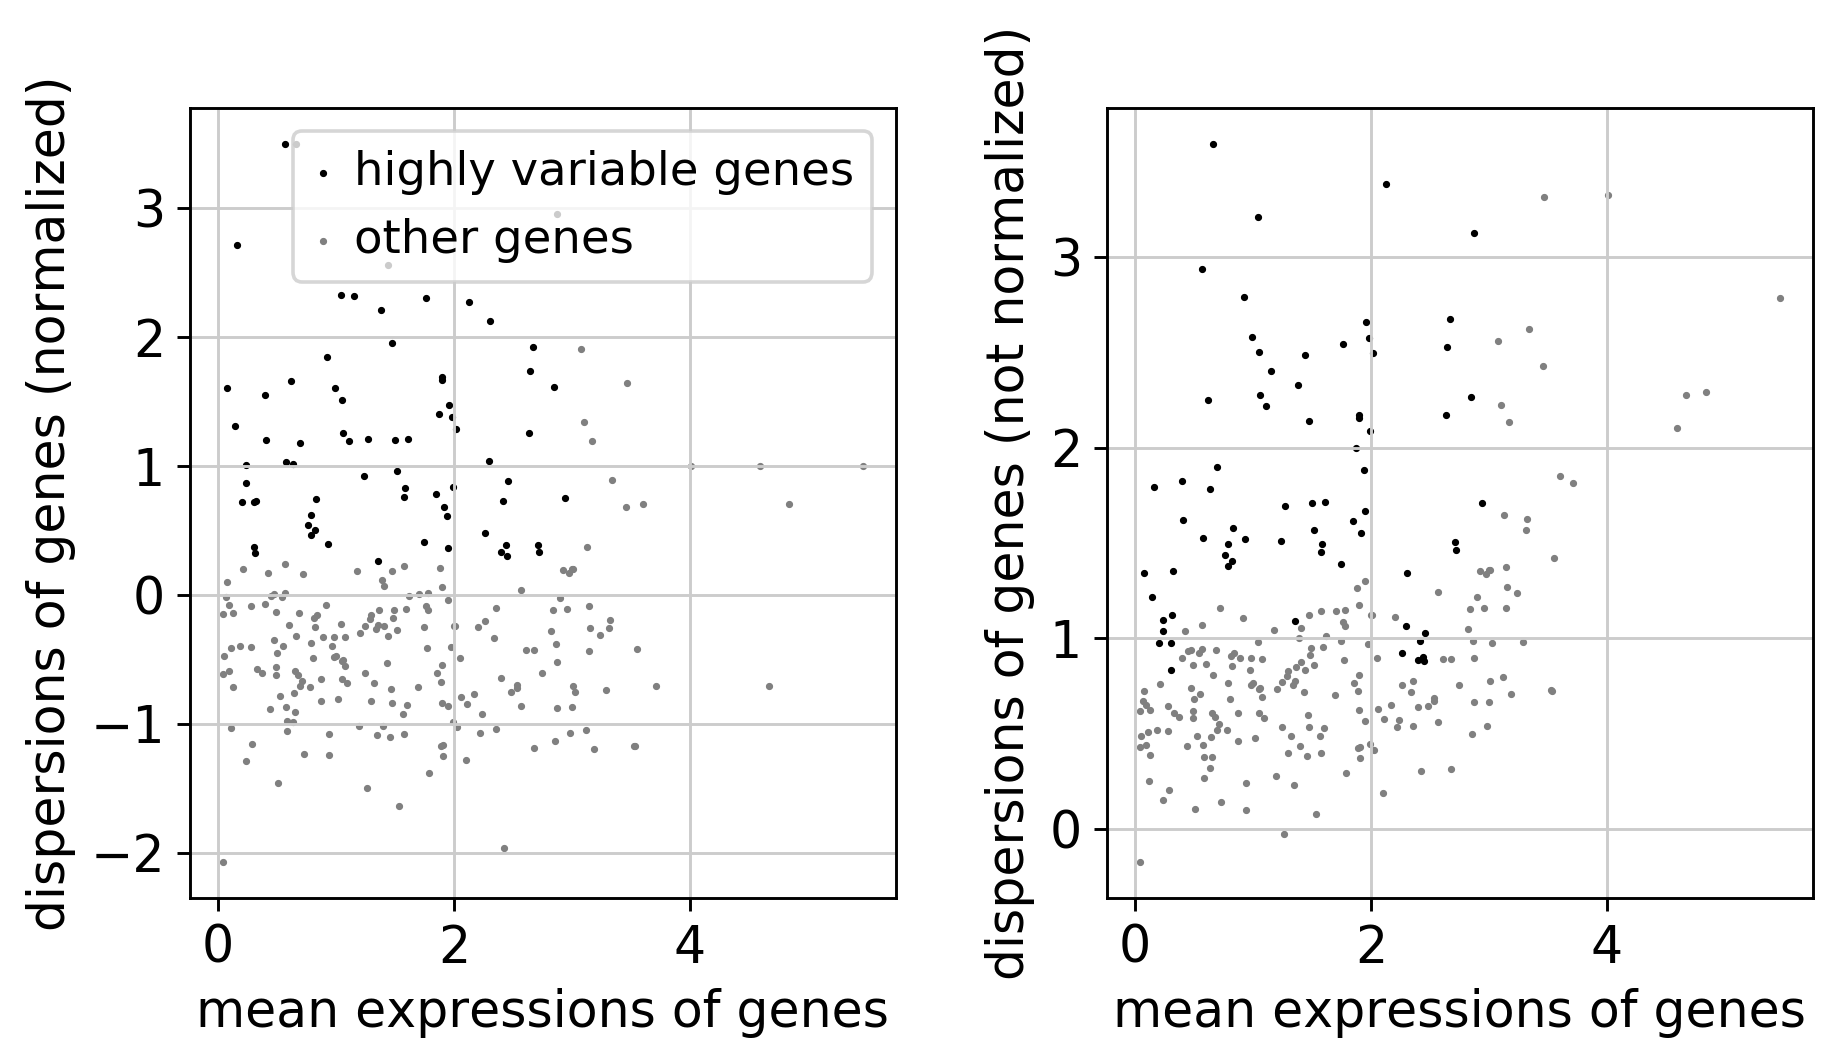

In [11]:
sc.pp.highly_variable_genes(adata_cc_genes, min_mean=0.0125, max_mean=3, min_disp=0.25)
sc.pl.highly_variable_genes(adata_cc_genes)

In [12]:
np.sum(adata_cc_genes.var['highly_variable'])

72

In [13]:
sc.pp.scale(adata_cc_genes, max_value=10)

In [14]:
sc.tl.pca(adata_cc_genes, svd_solver='arpack')

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


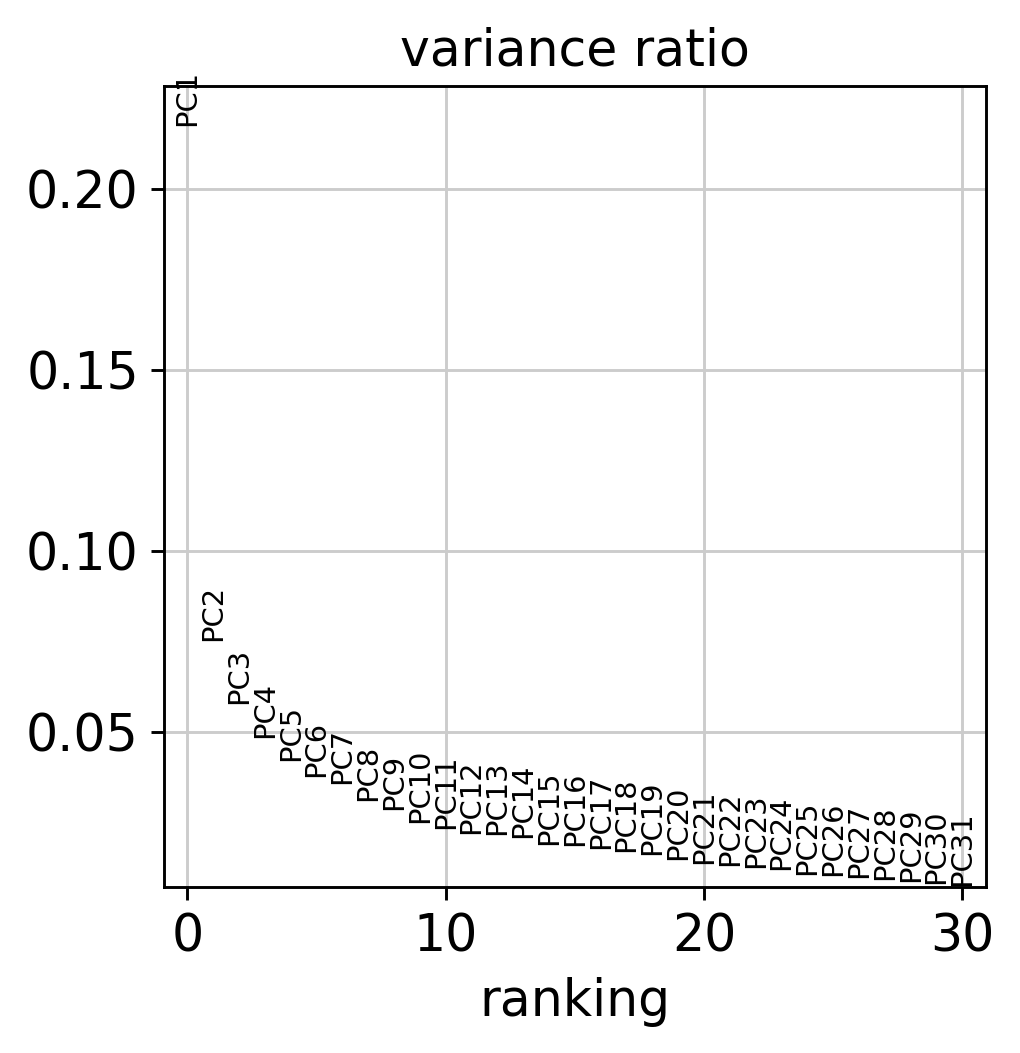

In [15]:
sc.pl.pca_variance_ratio(adata_cc_genes, log=False)# log = True

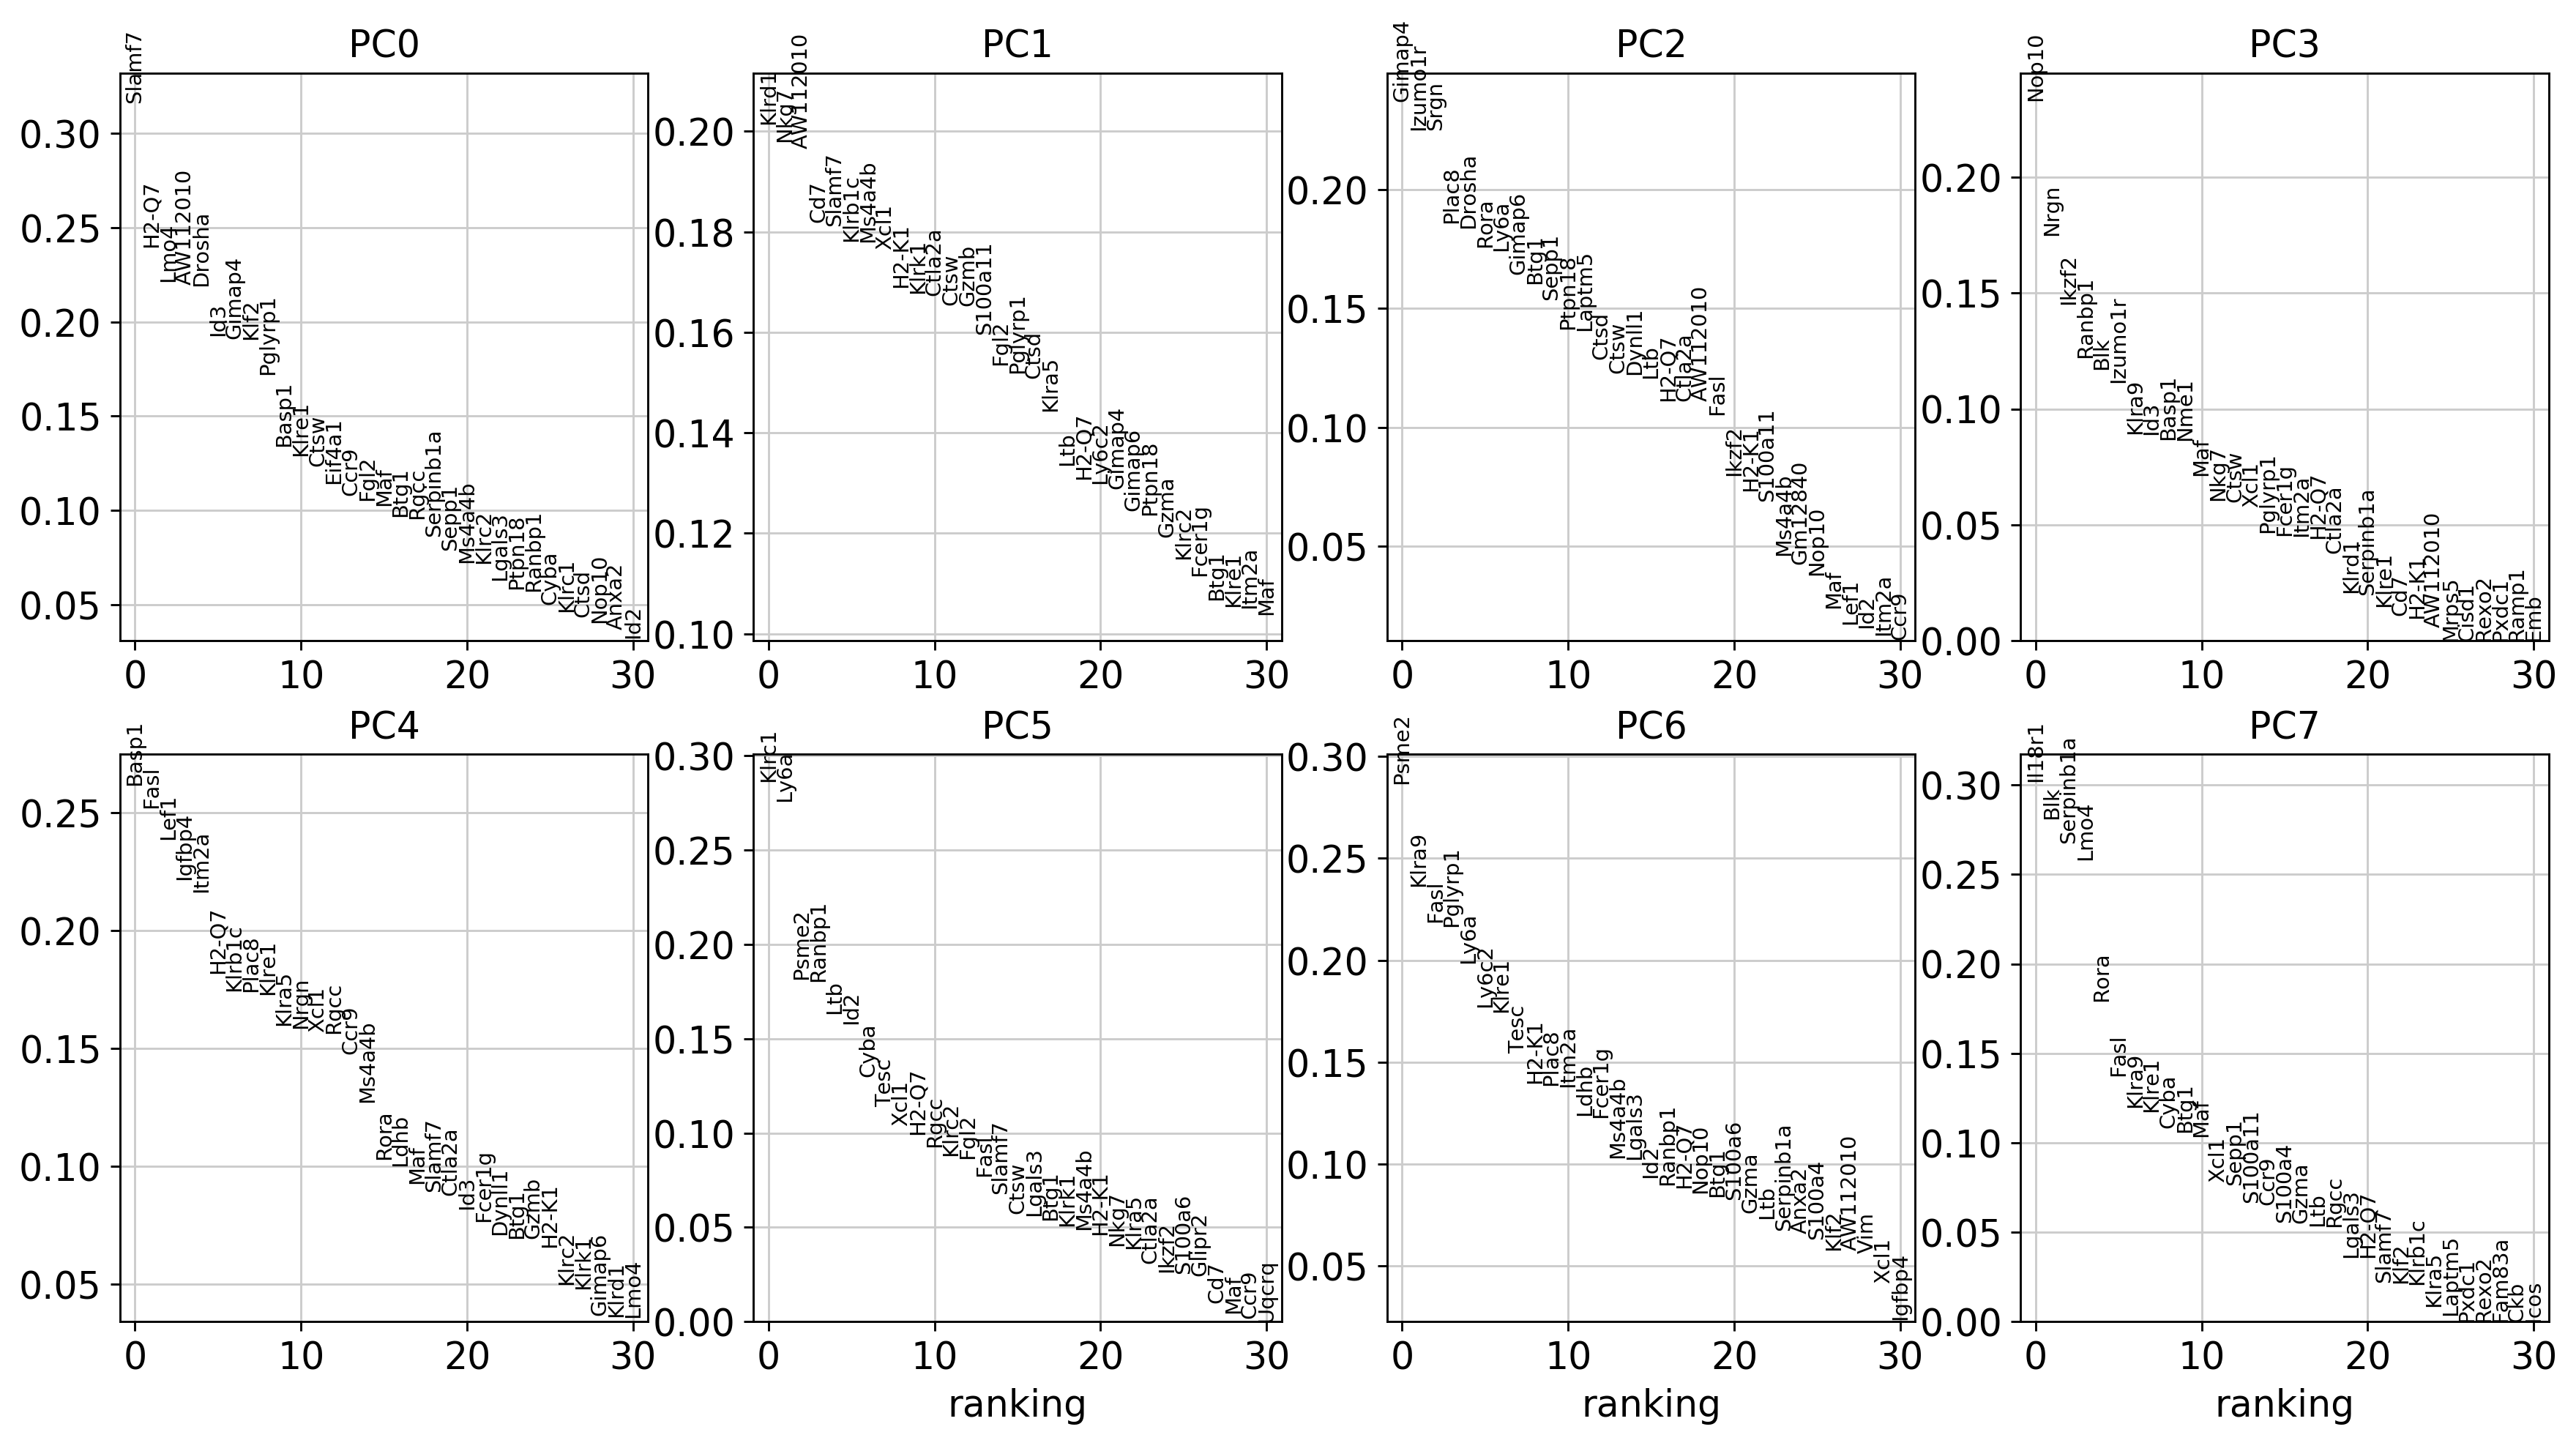

In [16]:
sc.pl.pca_loadings(adata_cc_genes, components=list(range(0,8)))

In [17]:
sc.pp.neighbors(adata_cc_genes, n_neighbors=10, n_pcs = 8)

computing neighbors
    using 'X_pca' with n_pcs = 8
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)


In [18]:
sc.tl.umap(adata_cc_genes)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 3 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


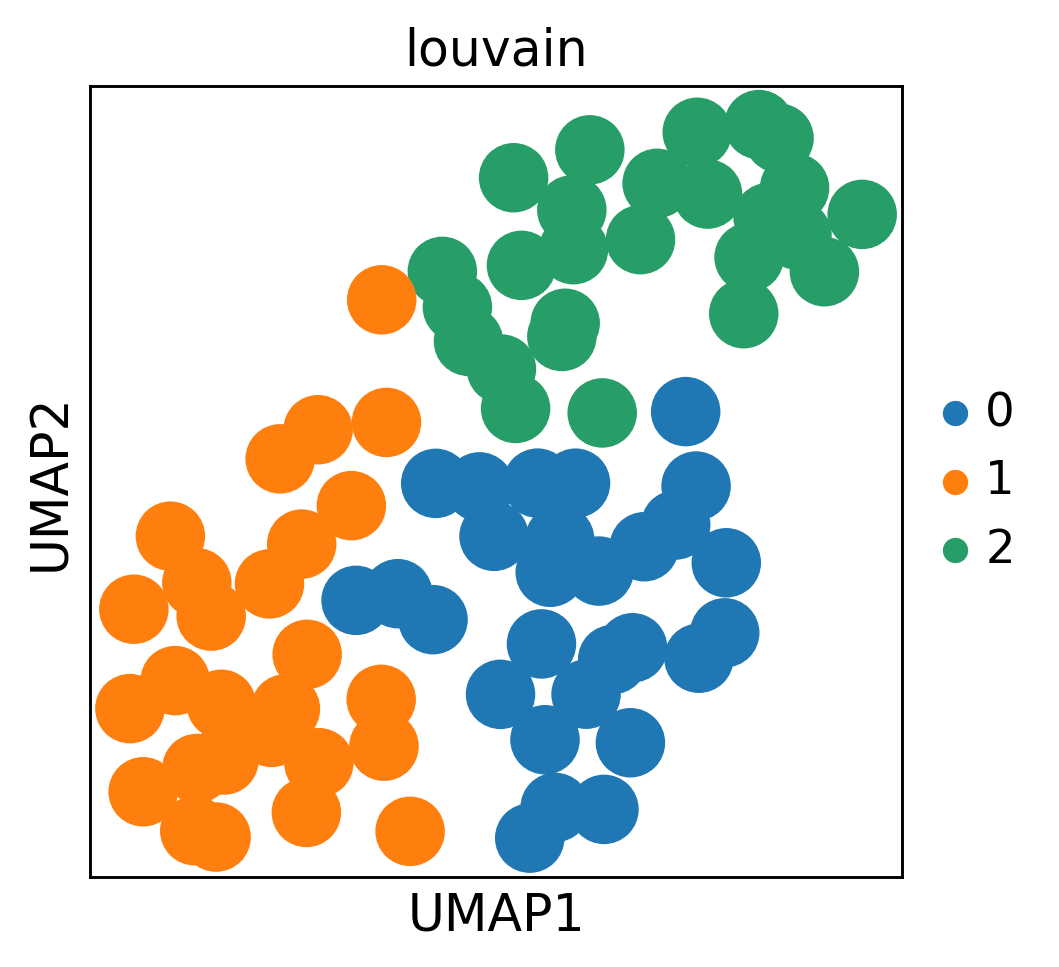

In [19]:
sc.tl.louvain(adata_cc_genes, resolution=0.5)
sc.pl.umap(adata_cc_genes, color=['louvain'], save="_figure3a.pdf")

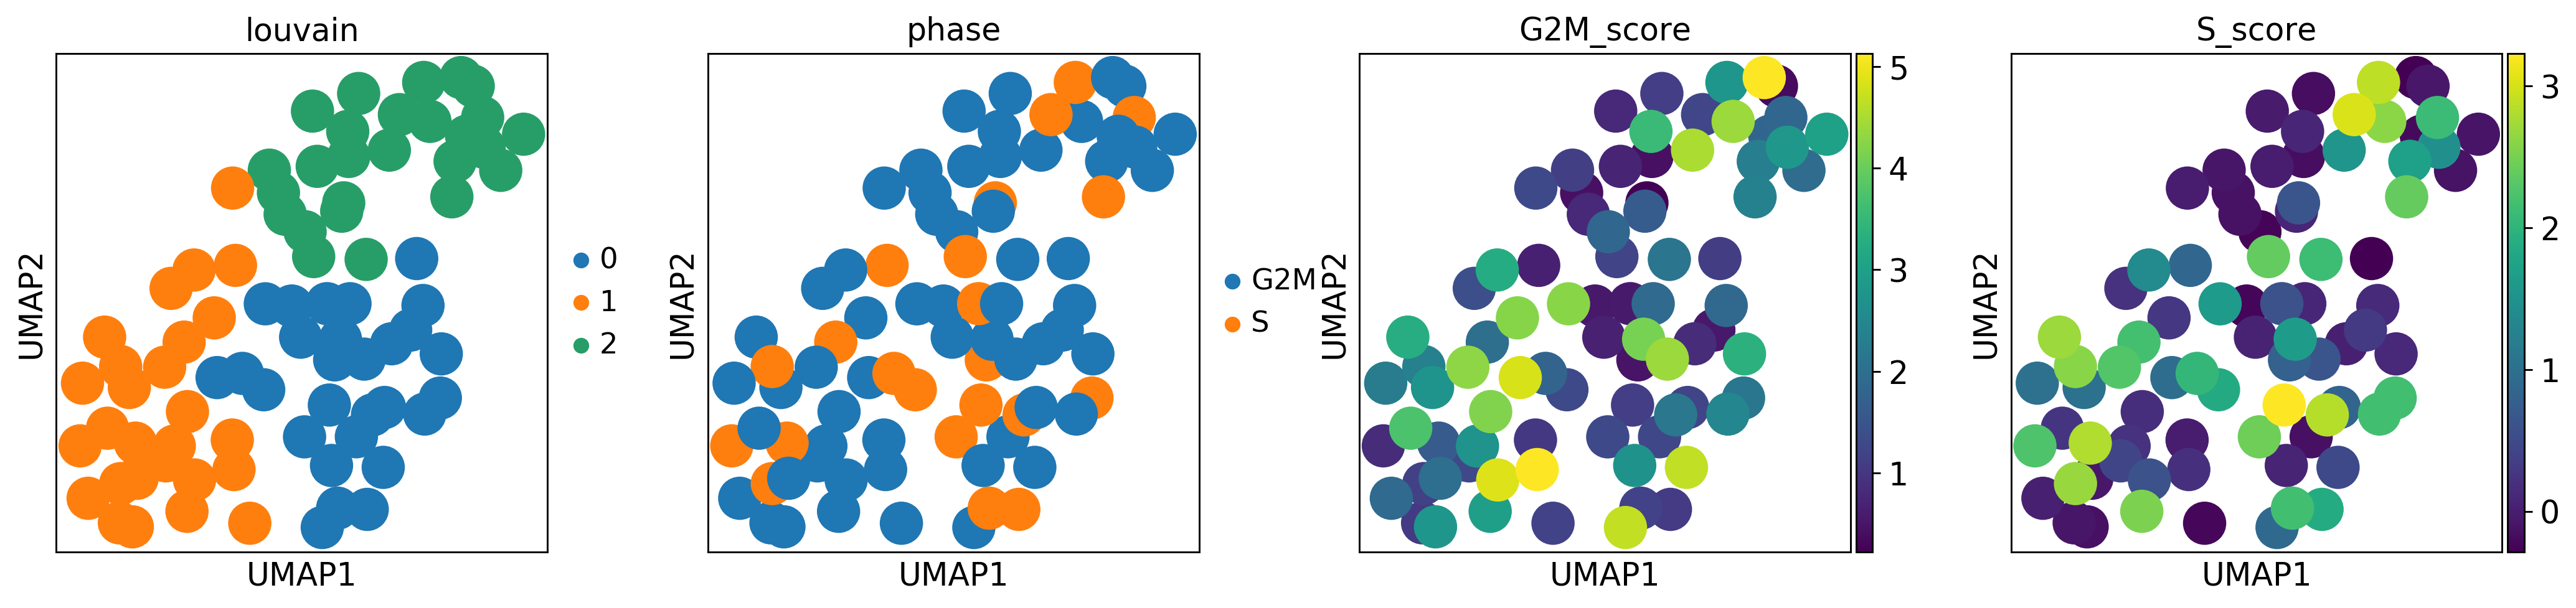

In [20]:
sc.pl.umap(adata_cc_genes, color=['louvain','phase','G2M_score','S_score'], edges = False)

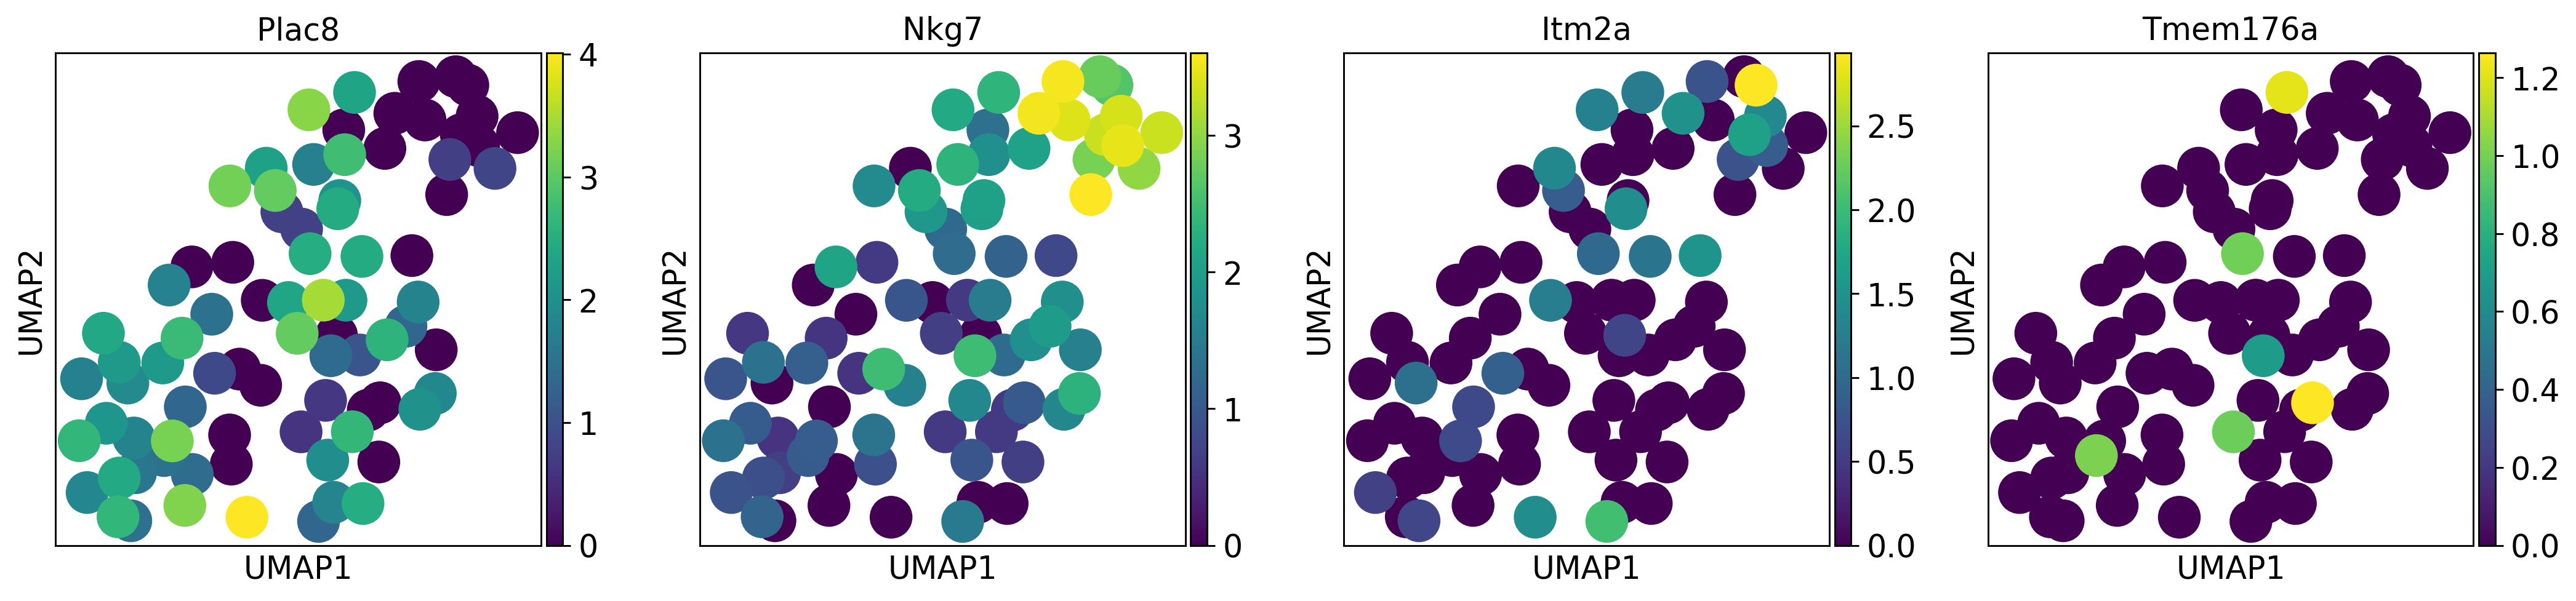

In [21]:
sc.pl.umap(adata_cc_genes, color=['Plac8','Nkg7','Itm2a','Tmem176a'], edges = False)

In [22]:
sc.tl.rank_genes_groups(adata_cc_genes, 'louvain', use_raw=False, method='wilcoxon', n_genes=100)
pd.DataFrame(adata_cc_genes.uns['rank_genes_groups']['names']).head(20)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


,0,1,2
0,Gnb2l1,Ccr9,AW112010
1,Nme1,Tesc,Ctsd
2,Eif5a,Igfbp4,Ctsw
3,Ybx1,Rgcc,Nkg7
4,Gm8730,Pdlim1,Ms4a4b
5,Gm10073,Lmo4,H2-D1
6,Mif,Ccr7,H2-K1
7,Hsp90ab1,Lef1,Ptpn18
8,Id3,Lgals1,Ly6e
9,Nop10,Lztfl1,Klrd1


In [23]:
#marker_genes = ['Lef1','Itm2a','Zbtb16','Plac8','Izumo1r','Ifit1','Ifit3','Isg15','Ly6a','Fhl2','Nkg7','Fcer1g','Gzma','Gzmb','Rorc','Serpinb1a','Tmem176a','Tmem176b']
#ax = sc.pl.tracksplot(adata_cc_genes, marker_genes, groupby='louvain')
#sc.pl.rank_genes_groups_tracksplot(adata_cc_genes, n_genes=10)

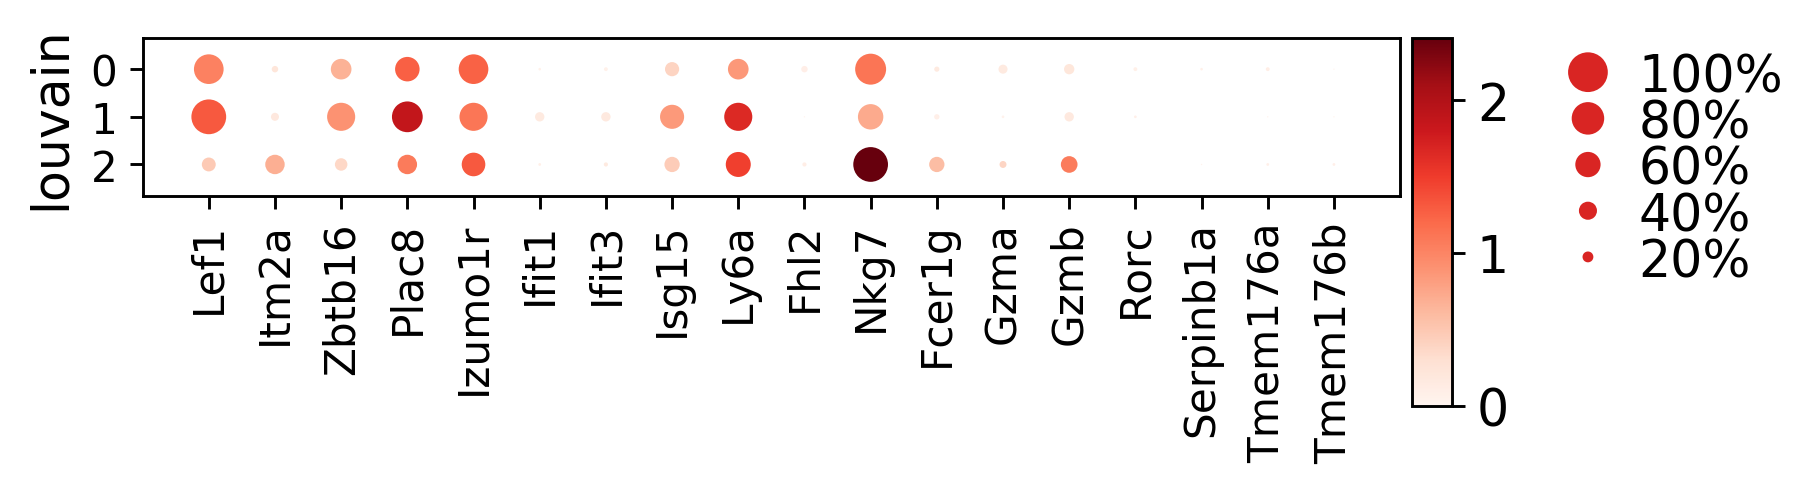

In [24]:
marker_genes = ['Lef1','Itm2a','Zbtb16','Plac8','Izumo1r','Ifit1','Ifit3','Isg15','Ly6a','Fhl2','Nkg7','Fcer1g','Gzma','Gzmb','Rorc','Serpinb1a','Tmem176a','Tmem176b']
ax = sc.pl.dotplot(adata_cc_genes, marker_genes, groupby='louvain')

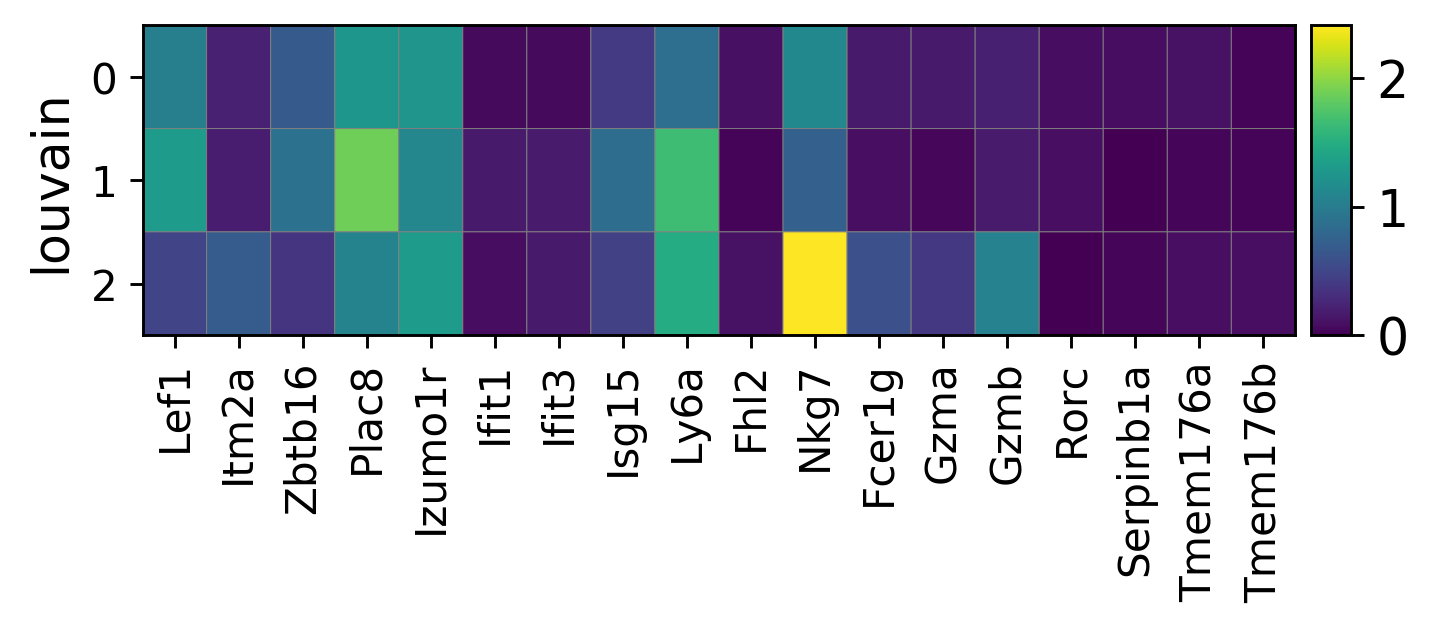

GridSpec(2, 3, height_ratios=[0, 10.5], width_ratios=[5.76, 0, 0.2])

In [25]:
sc.pl.matrixplot(adata_cc_genes, marker_genes, groupby='louvain')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_louvain']`


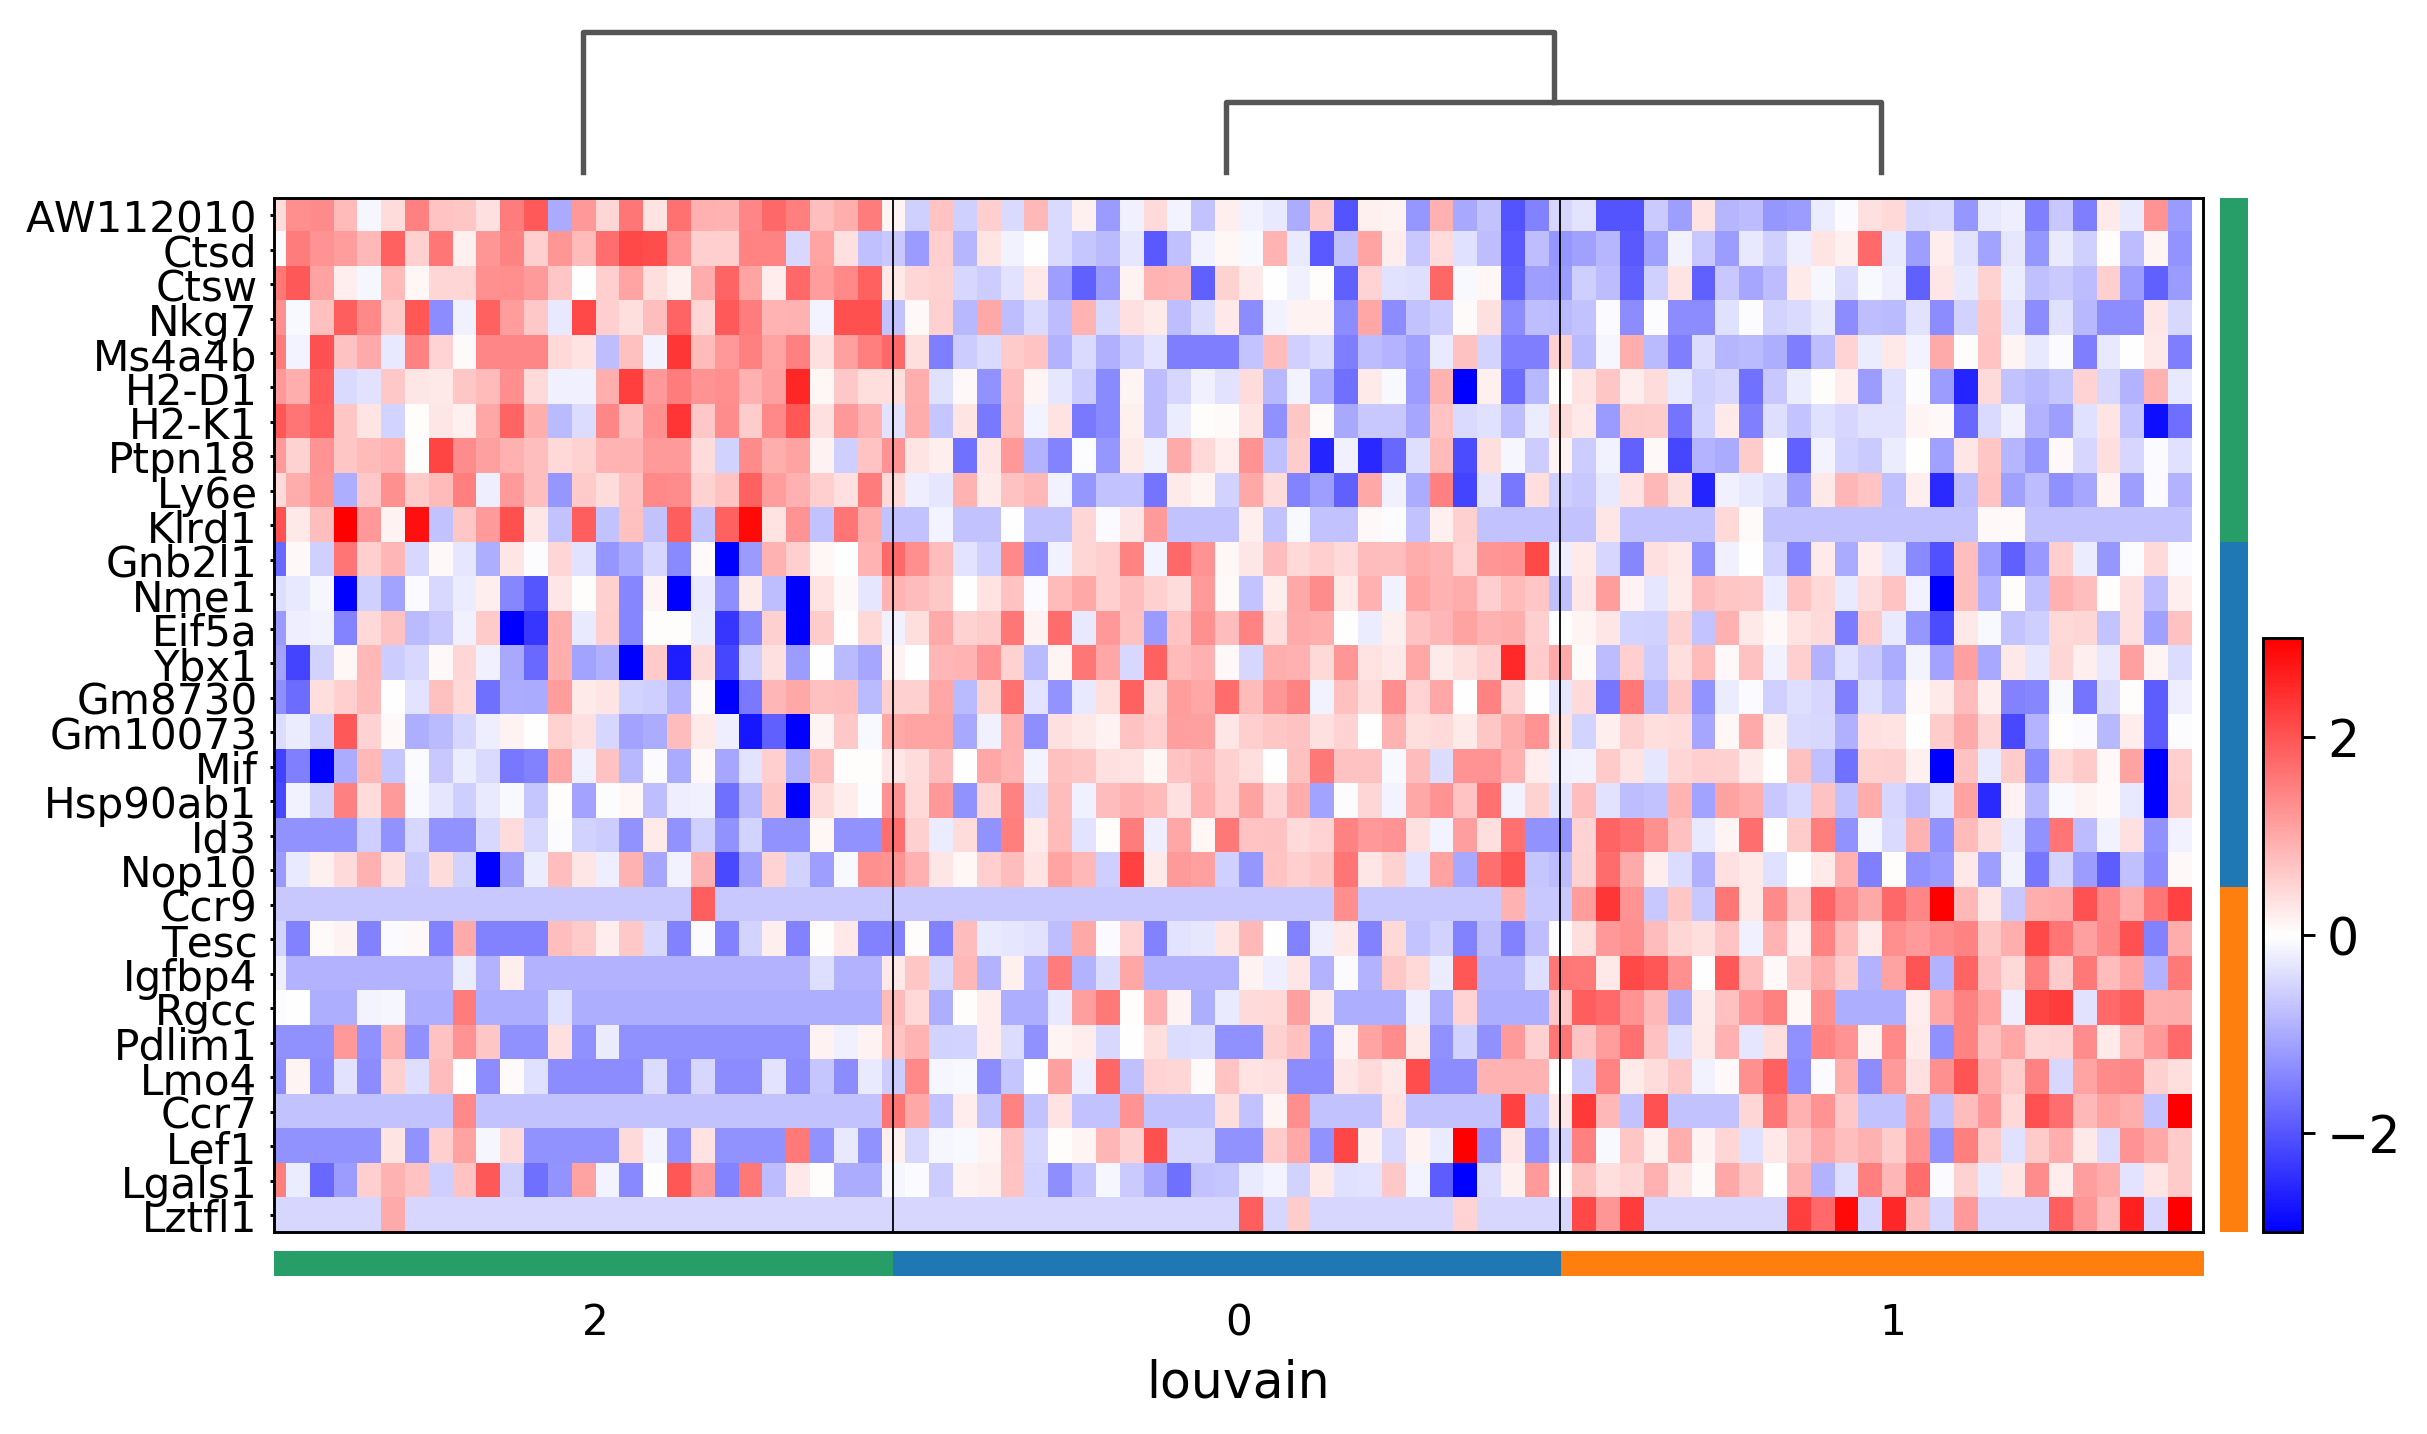

In [26]:
sc.pl.rank_genes_groups_heatmap(adata_cc_genes, n_genes=10, key='rank_genes_groups',
                                swap_axes=True, use_raw=False, vmax=3, vmin=-3, cmap='bwr', dendrogram=True)

# Export gene markers

In [27]:
cell_type_nb = {}
list_cell_type = adata_cc_genes.obs['louvain'].unique().tolist()
list_cell_type.sort()
for i in range(0, len(adata_cc_genes.obs['louvain'].unique().tolist())):
    cell_type_nb[list_cell_type[i]] = i


In [28]:
clusters = []
genes = []
logFC = []
score = []
pvals = []
pvals_adj = []

for cl in cell_type_nb.keys():
    clusters = clusters + ([cl]*len(adata_cc_genes.uns['rank_genes_groups']['names'][str(cl)]))
    genes = genes + adata_cc_genes.uns['rank_genes_groups']['names'][str(cl)].tolist()
    logFC = logFC + adata_cc_genes.uns['rank_genes_groups']['logfoldchanges'][str(cl)].tolist()
    score = score + adata_cc_genes.uns['rank_genes_groups']['scores'][str(cl)].tolist()
    pvals = pvals + adata_cc_genes.uns['rank_genes_groups']['pvals'][str(cl)].tolist()
    pvals_adj = pvals_adj + adata_cc_genes.uns['rank_genes_groups']['pvals_adj'][str(cl)].tolist()
    

In [29]:
markers = pd.DataFrame(data = {'clusters': clusters,
                              'genes':genes,
                              'logFC':logFC,
                              'score':score,
                              'pvals':pvals,
                              'pvals_adj':pvals_adj,
                              })

In [30]:
markers.to_csv(path_or_buf = 'cycling.markers.csv', sep = ',', index = False)